# neuralcoref
#### Features
##### Mention features:
1. Word vectors for the first, last, and head words of the mention.
2. The average of all word vectors in the mention.
3. The 10 features used by Rescanes et al. (2013) for singleton mention identification,which capture aspects of a mention like the gender, animacy, quantification, and negation.
4. The dependency relation between the head word of the mention and its parent (binary feature on the 10 most common dependency relations).

##### Context features:
The average of the word vectors of all words to the left (or right) of the mention in a window
of 1, 5, or infinity (e.g., the entire sentence to the left of the mention).

##### Mention-Relating features:
1. The distance between the mentions in number of sentences and number of intervening mentions. Distances are binned (e.g., one bin might denote a sentence distance between 5 and 10) and then encoded as a 1-hot vector.
2. Two binary speaker identification features classifying the mentions as either being almost certainly coreferent or incompatible for coreference (e.g., “you” and “me” from the same speaker are incompatible).
3. Three binary string matching features indicating if the mentions have matching head words, match partially, or match exactly.

#### Neural Network Architecture:

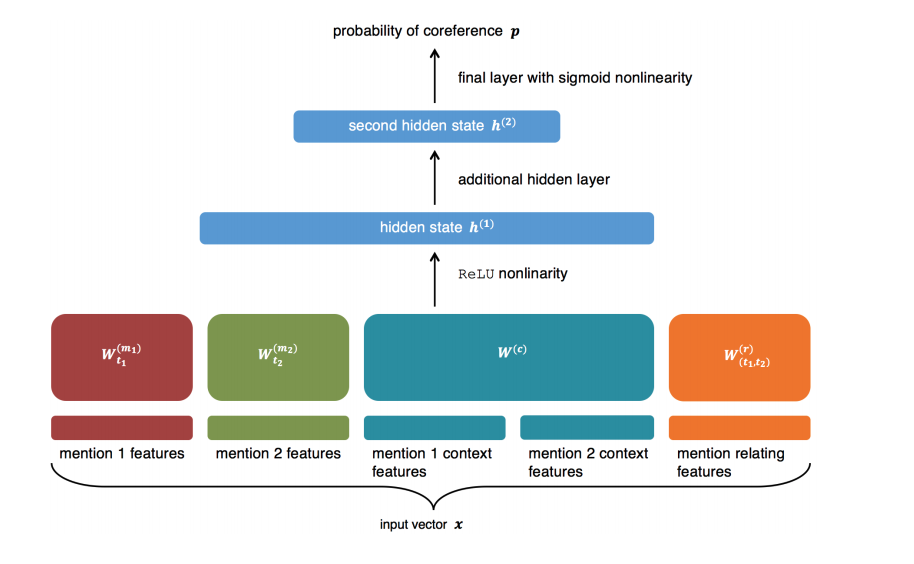

#### Incremental Coreference Model:
Mention pair model is not enough to perform binary classification because there is no enforce transitivity between mention pair(a,b) and pair(b,c) to ensure pair(a,c). A more reasonable way is to classify between two mention of clusters. This has the advantage of allowing earlier coreference decisions to inform later ones.

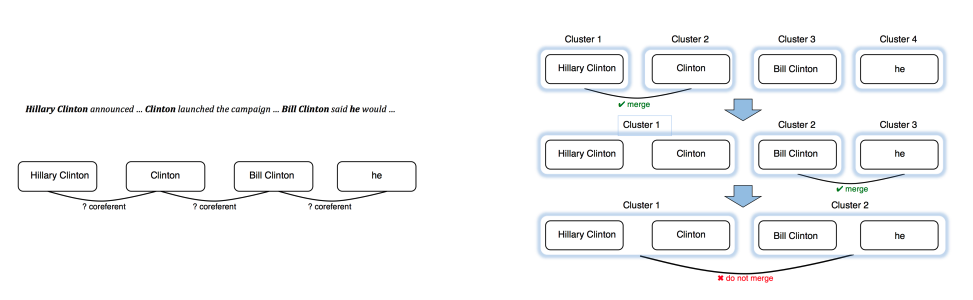

At each step, classifier(agent) observes the current state, which consists of all partially formed coreference clusters produced so far, and selects some action which merges two existing clusters. The action will result
in a new state with new candidate actions and the process is repeated.

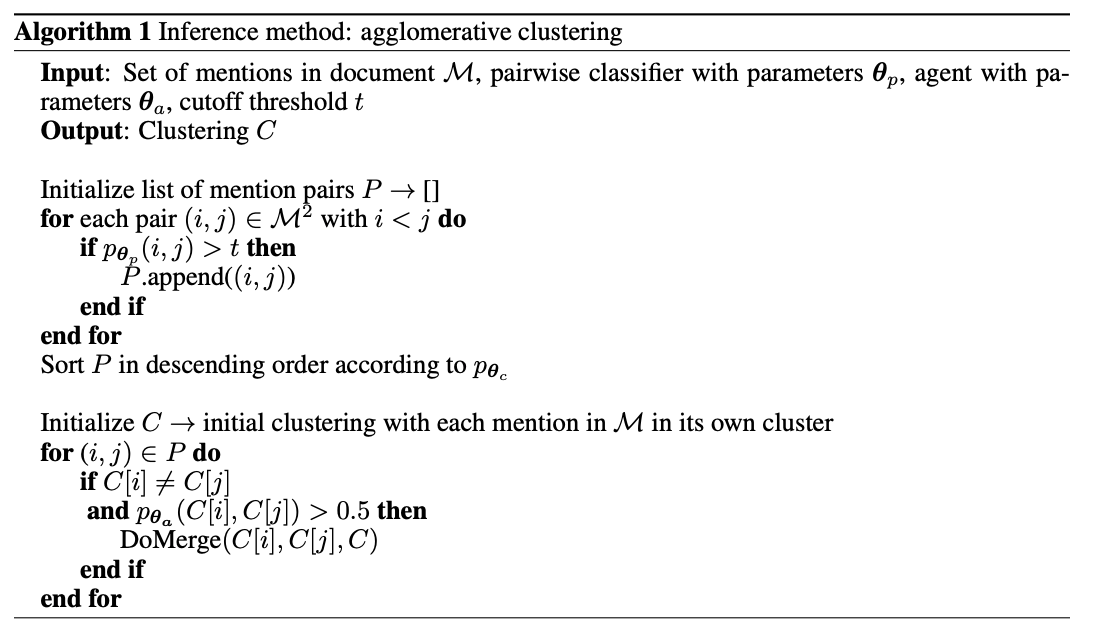
Result from Neural Coreference Resolution with Deep Biaffine Attention by Joint Mention Detection and Mention Clustering
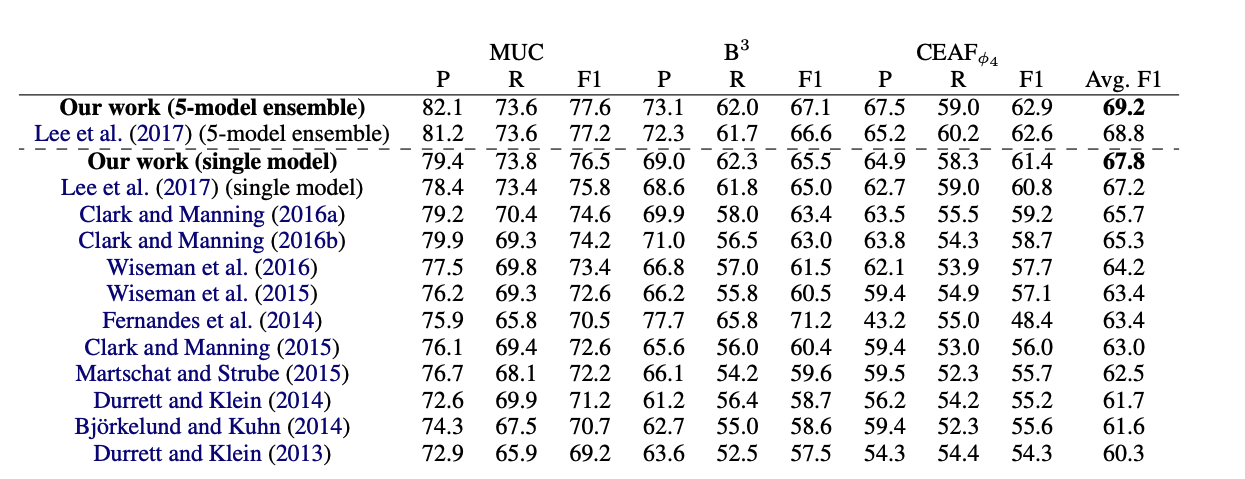


In [49]:
import json
import spacy
import string
import neuralcoref
from spacy.tokens import Span
from spacy import displacy
nlp = spacy.load("en_core_web_lg")
neuralcoref.add_to_pipe(nlp, greedyness=0.5)
with open("/Users/leo/PycharmProjects/EECS4080/train-v2.0.json") as f:
    data = json.load(f)
count = 0
result = []
for i in range(2):
    for d in data["data"][i]["paragraphs"]:
        if count == 20:
             break
        if "context" in d.keys():
            # print(d["context"])
            result.append(d["context"])
            # print("\n---------------------------------------------------------------------------\n")
            count += 1
    
text="\n".join(result)
# print(text)   
doc = nlp(text)
doc._.has_coref



True

### coreference clusters
Coreference is a list of cluster. \
Each cluster has the format of an entity followed by a list of entities that are coreferences to it. \
E.g. Beyoncé Giselle Knowles: [Beyoncé Giselle Knowles, her, her, She, she, Her, she, she, She, Girl, her] \
A greedyness parameter is used to define how many coreference one entity can have. A default greedyness is 0.5. The higher the greedyness is, the more coreferences one entity will include. 


In [50]:
clusters = doc._.coref_clusters
for cluster in clusters:
    print(cluster)

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981): [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981), she, her, her, she, her, Her, her, her]
R&B girl-group Destiny's Child: [R&B girl-group Destiny's Child, the group]
the world's best-selling girl groups of all time: [the world's best-selling girl groups of all time, Their]
Beyoncé: [Beyoncé, Beyoncé, Beyoncé, her, her, Her, Beyoncé, her, her, she, her, She, her, her, her, her]
Destiny's Child: [Destiny's Child, Destiny's Child, Destiny's Child, Destiny's Child, Destiny's Child, Destiny's Child]
Her critically acclaimed fifth studio album, Beyoncé (2013): [Her critically acclaimed fifth studio album, Beyoncé (2013), its]
America: [America, America]
Billboard: [Billboard, Billboard]
the Top Female Artist of: [the Top Female Artist of, their]
Beyoncé Giselle Knowles: [Beyoncé Giselle Knowles, her, her, She, she, Her, she, she, She, Girl, her]
her mother: [her mother, her 

Remove the cluster whose main entity is a pronoun

In [51]:
def remove_pronouns(clusters):
    for idx, cluster in enumerate(clusters):
        if len(cluster.main) == 1 and cluster.main.lemma_ == "-PRON-":
            removed = clusters.pop(idx)
            print("removed: ", removed)

    
remove_pronouns(clusters)
for cluster in clusters:
    print(cluster, "\n")

removed:  their: [their, their]
removed:  Her: [Her, her, she, herself, her, she, her, she, her, her]
removed:  she: [she, she]
removed:  Her: [Her, Her, she, her, her, her, her, her, her]
removed:  her: [her, her]
removed:  her: [her, her, she, her]
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981): [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981), she, her, her, she, her, Her, her, her] 

R&B girl-group Destiny's Child: [R&B girl-group Destiny's Child, the group] 

the world's best-selling girl groups of all time: [the world's best-selling girl groups of all time, Their] 

Beyoncé: [Beyoncé, Beyoncé, Beyoncé, her, her, Her, Beyoncé, her, her, she, her, She, her, her, her, her] 

Destiny's Child: [Destiny's Child, Destiny's Child, Destiny's Child, Destiny's Child, Destiny's Child, Destiny's Child] 

Her critically acclaimed fifth studio album, Beyoncé (2013): [Her critically acclaimed fifth studio album, Beyoncé (2013

In [52]:
def merge_identical_entity(clusters):
    a_dict = {}
    for idx, cluster in enumerate(clusters):
        if cluster.main.text.strip() not in a_dict.keys():
            a_dict[cluster.main.text.strip()] = cluster
        else:
            a_dict[cluster.main.text.strip()].mentions.extend(cluster.mentions)
            clusters.pop(idx)

merge_identical_entity(clusters)
for cluster in clusters:
   print(cluster, "\n")


Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981): [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981), she, her, her, she, her, Her, her, her] 

R&B girl-group Destiny's Child: [R&B girl-group Destiny's Child, the group] 

the world's best-selling girl groups of all time: [the world's best-selling girl groups of all time, Their] 

Beyoncé: [Beyoncé, Beyoncé, Beyoncé, her, her, Her, Beyoncé, her, her, she, her, She, her, her, her, her, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, its, Beyoncé, Beyoncé, Beyoncé, Beyoncé, her, its, Beyoncé, It, its, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Her, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, It, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, Beyoncé, its, Beyoncé, Beyoncé, her, her, she, her, Beyoncé, her, Beyoncé, Beyoncé, she, she, Her, Beyoncé, her, Beyoncé, Beyoncé

In [53]:
def find_overlaping(clusters):
    a_dict = {}  # key is index of cluster in clusters, value is soome clusters overlapping with it
    clusters.sort(key=lambda cluster: cluster.main.text)
    for idx, cluster in enumerate(clusters):
        is_substring = False
        for key in a_dict.keys():
            if len(key.main.text) >= len(cluster.main.text):
                if cluster.main.text in key.main.text:
                    a_dict[key].append(cluster)
                    is_substring = True
            else:
                if key.main.text in cluster.main.text:
                    a_dict[key].append(cluster)
                    is_substring = True
        if not is_substring:
            a_dict[cluster] = [cluster]
    return a_dict

a_dict = find_overlaping(clusters)
for key in a_dict:
    #  if len(a_dict[key])>1:
    for idx, entity1 in enumerate(a_dict[key]):
        print(key.main.text+": ", entity1.main)
    print()


        


Ali Larter:  Ali Larter

America:  America
America:  North America
America:  the Verizon Ladies First Tour in North America

Australia:  Australia

B'Day:  B'Day
B'Day:  Beyoncé's second solo album B'Day

Beyoncé:  Beyoncé
Beyoncé:  Beyoncé Giselle Knowles
Beyoncé:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981)
Beyoncé:  Beyoncé and Gaga
Beyoncé:  Beyoncé and childhood friend Kelly Rowland
Beyoncé:  Beyoncé was one of many entertainers who performed for the family of Libyan ruler Muammar Gaddafi
Beyoncé:  Beyoncé's father
Beyoncé:  Beyoncé's second consecutive number-one album in the United States
Beyoncé:  Beyoncé's second solo album B'Day
Beyoncé:  Her critically acclaimed fifth studio album, Beyoncé (2013)

Billboard:  Billboard
Billboard:  the Billboard 200
Billboard:  the Billboard Hot 100 chart

Cadillac Records:  Cadillac Records

Destiny:  Destiny
Destiny:  Destiny's Child
Destiny:  R&B girl-group Destiny's Child

Farrah Franklin:  Farrah Fr

In [54]:
a_dict = find_overlaping(clusters)
for key in a_dict:
    if len(a_dict[key])>1:
        for idx, entity1 in enumerate(a_dict[key]):
            # print(key+": ", entity1.main)
            for entity2 in a_dict[key][idx:]:
                print(entity1.main.text+": ", entity2.main.text+": ", entity1.main.similarity(entity2.main))
            print()

America:  America:  1.0
America:  North America:  0.8359508848999222
America:  the Verizon Ladies First Tour in North America:  0.6656021676665258

North America:  North America:  1.0
North America:  the Verizon Ladies First Tour in North America:  0.7768834530830201

the Verizon Ladies First Tour in North America:  the Verizon Ladies First Tour in North America:  1.0

B'Day:  B'Day:  1.0
B'Day:  Beyoncé's second solo album B'Day:  0.0

Beyoncé's second solo album B'Day:  Beyoncé's second solo album B'Day:  1.0

Beyoncé:  Beyoncé:  1.0
Beyoncé:  Beyoncé Giselle Knowles:  0.8074390098782755
Beyoncé:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981):  0.17626974325520275
Beyoncé:  Beyoncé and Gaga:  0.7888737327340585
Beyoncé:  Beyoncé and childhood friend Kelly Rowland:  0.5088564898793274
Beyoncé:  Beyoncé was one of many entertainers who performed for the family of Libyan ruler Muammar Gaddafi:  0.10480491704335938
Beyoncé:  Beyoncé's father:  0.52802

/Users/leo/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  "__main__", mod_spec)


In [55]:
a_dict = find_overlaping(clusters)
def merge_potential_coreference(clusters):
    merge_identical_entity(clusters)
    a_dict = find_overlaping(clusters)
    for key in a_dict:
        if len(a_dict[key])>1:
            main_entity = a_dict[key][0]
            main_entity_len = len(main_entity.main)
            print("main_entity: ", main_entity.main)
            print("--------------")
            for idx, entity in enumerate(a_dict[key][1:]):
                # find entities whose start is identical to main entity 
                if entity.main[:main_entity_len].text == main_entity.main.text:
                    # if main entity follows with 's, conjunction, or preposition then don't merge
                    if entity.main[main_entity_len].pos_ in ["PART", "ADP", "CCONJ"]:
                        print(entity.main.text, "don't merge")
                    else:
                        print(entity.main.text, "to merge")
                        main_entity.mentions.extend(entity.mentions)
                        clusters.remove(entity)

                    print()
            print("*************")
merge_potential_coreference(clusters)
for cluster in clusters:
    print(cluster)
    print()

main_entity:  America
--------------
*************
main_entity:  B'Day
--------------
*************
main_entity:  Beyoncé
--------------
Beyoncé Giselle Knowles to merge

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) to merge

Beyoncé and Gaga don't merge

Beyoncé and childhood friend Kelly Rowland don't merge

Beyoncé was one of many entertainers who performed for the family of Libyan ruler Muammar Gaddafi to merge

Beyoncé's father don't merge

Beyoncé's second consecutive number-one album in the United States don't merge

Beyoncé's second solo album B'Day don't merge

*************
main_entity:  Billboard
--------------
*************
main_entity:  Destiny
--------------
Destiny's Child don't merge

*************
main_entity:  Her first solo album Dangerously in Love
--------------
*************
main_entity:  Luckett and Roberson
--------------
*************
main_entity:  Michelle Williams
--------------
Michelle Williams and Kelly Rowland don't m

In [56]:
import networkx as nx

62


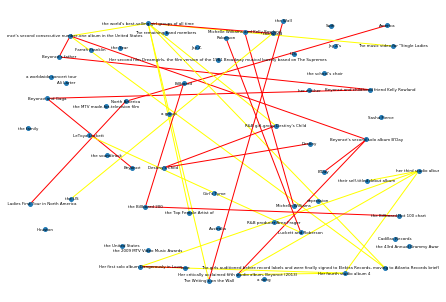

In [57]:
import matplotlib.pyplot as plt
G = nx.Graph()
node_num = 0
for cluster in clusters:
    G.add_node(cluster.main)
    node_num += 1
    for cluster2 in clusters:
        if cluster.main.text != cluster2.main.text and cluster.main and cluster.main.vector_norm and cluster2.main and cluster2.main.vector_norm:
            if cluster.main.similarity(cluster2.main) > 0.8:
                # print(cluster.main.text, cluster2.main.text)
                G.add_edge(cluster.main,cluster2.main,color='yellow')
        
overlap = find_overlaping(clusters)
for k in overlap:
    nx.add_path(G, [c.main for c in overlap[k]], weight=1, color='red')
print(node_num)    
edge_colors = nx.get_edge_attributes(G, 'color')
pos = nx.spring_layout(G,k=0.9,iterations=2)
nx.draw(G, pos, node_size=15, font_size=4,with_labels=True,edge_color=edge_colors.values())
plt.savefig("/Users/leo/Desktop/nx.png", dpi=300)
plt.draw()
plt.show()

    
    


74


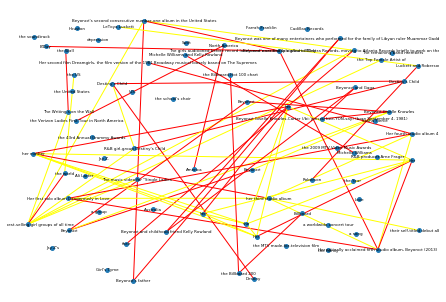

In [58]:
doc2 = nlp(text)
old_clusters = doc2._.coref_clusters
G2 = nx.Graph()
node_num=0
for cluster in old_clusters:
    G2.add_node(cluster.main)
    node_num += 1
    for cluster2 in old_clusters:
        if cluster.main.text != cluster2.main.text and cluster.main and cluster.main.vector_norm and cluster2.main and cluster2.main.vector_norm:
            if cluster.main.similarity(cluster2.main) > 0.8:
                # print(cluster.main.text, cluster2.main.text)
                G2.add_edge(cluster.main,cluster2.main,color='yellow')
        
overlap = find_overlaping(old_clusters)
for k in overlap:
    nx.add_path(G2, [c.main for c in overlap[k]], weight=1, color='red')
print(node_num)
edge_colors = nx.get_edge_attributes(G2, 'color')
pos = nx.spring_layout(G2,k=0.9,iterations=2)
nx.draw(G2, pos, node_size=15, font_size=4,with_labels=True,edge_color=edge_colors.values())
plt.savefig("/Users/leo/Desktop/old_nx.png", dpi=300)
plt.draw()
plt.show()


In [59]:
from tqdm import tqdm
# sentence segmentation
def sentenceSegmentation(text):
    doc3 = nlp(text)
    obj_count = 0
    sbj_count = 0
    sbjpass_count = 0
    pobj_count = 0
    candidate_sentences = [] 
    sentence_count = 0
    for idx, sent in enumerate(doc3.sents):
        sentence_count += 1
        for tok in sent:
            if tok.dep_ =="nsubj":
                sbj_count += 1
            if tok.dep_ =="dobj":
                obj_count += 1
            if tok.dep_ == "nsubjpass":
                sbjpass_count += 1
            if tok.dep_ == "pobj":
                pobj_count += 1
        if sbj_count == 1 and obj_count == 1:
            candidate_sentences.append(sent)
        if sbjpass_count == 1 and pobj_count == 1:
            candidate_sentences.append(sent)
        if sbj_count == 1 and pobj_count == 1:
            candidate_sentences.append(sent)
        sbj_count = 0
        obj_count = 0
    number = 0
    for sent in candidate_sentences:
        number += 1
        print(sent.text)
    recall = float(number)/sentence_count
    print("recall: {:.2f}".format(recall))
    return candidate_sentences

In [60]:
def sentenceSegmentation2(text):
    doc3 = nlp(text)
    verbs = []
    verb_count = 0
    append = False
    for idx, sent in enumerate(doc3.sents):
        for tok in sent:
            if tok.pos_ == "VERB":
                verb_count += 1
                nsubj = 0
                subjpass = 0
                pobj = 0
                dobj = 0
                attr = 0
                for child in tok.children:
                    if child.dep_ == "nsubj":
                        nsubj += 1
                    if child.dep_ == "dobj":
                        dobj += 1
                    if child.dep_ == "nsubjpass":
                        subjpass += 1
                    if child.dep_ == "pobj":
                        pobj += 1
                    if child.dep_ == "attr":
                        attr += 1
                    if (nsubj ==1 and dobj == 1) or (nsubj == 1 and pobj == 1) or (subjpass == 1 and pobj == 1) or (nsubj == 1 and attr == 1):
                        append = True
                if append:
                    verbs.append(tok)
                    append = False
    print(verb_count)
    return verbs

In [61]:
# get subject, relation, object triples
def get_entities(sent, doc):  
    result = []
    sub_entity = None
    sub_tok = None
    root = None
    obj_entity = None
    obj_tok = None
    for tok in sent:
        if tok.dep_ == "nsubj" or tok.dep_ == "nsubjpass":   
            sub_entity = doc[tok.left_edge.i:tok.right_edge.i+1]
            sub_tok = tok
        if tok.dep_ == "ROOT":
            root = tok
        if tok.dep_ == "dobj" or tok.dep_ == "pobj":
            obj_entity = doc[tok.left_edge.i:tok.right_edge.i+1]
            obj_tok = tok
    result = [sub_entity, sub_tok, root, obj_entity, obj_tok]
  #############################################################

    # return [ent1.strip(), ent2.strip()]
    return result  # [sub entity, sub token, relation, obj entity, obj token]

In [62]:
# get subject, relation, object triples
def get_entities2(verb, doc):  
    result = []
    sub_entity = None
    sub_tok = None
    obj_entity = None
    obj_tok = None
    for child in verb.children:
        if child.dep_ == "nsubj" or child.dep_ == "nsubjpass":   
            sub_entity = doc[child.left_edge.i:child.right_edge.i+1]
            sub_tok = child
        if child.dep_ == "dobj" or child.dep_ == "pobj" or child.dep_ == "attr":
            obj_entity = doc[child.left_edge.i:child.right_edge.i+1]
            obj_tok = child
    result = [sub_entity, sub_tok, verb, obj_entity, obj_tok]
    return result

        

In [63]:
# dictionary mapping index of tokens to coreference main entity
def create_tokidx_to_main_dict(clusters):
    dict_tokidx_main = {}
    for cluster in clusters:
        for ent in cluster:
            for tok in ent:
                dict_tokidx_main[tok.i] = cluster.main
    return dict_tokidx_main

In [64]:
# substitute sub and obj with coreference
def apply_coreference(triples, dict_tokidx_main):
    for triple in triples:
        if triple[1].i in dict_tokidx_main:
            print("1:", triple[1].i)
            triple[0] = dict_tokidx_main[triple[1].i]
        if triple[4].i in dict_tokidx_main:
            print("4:", triple[4].i)
            triple[3] = dict_tokidx_main[triple[4].i]


In [65]:
# # subject relation object triples
# for triple in triples:
#     print(triple[0], "|", triple[1], "|", triple[2], "|", triple[3], "|", triple[4])

In [66]:
# after using coreference
# G3 = nx.Graph()
# node_num=0
# color_map = []
# for triple in triples:
#     if triple[0] not in list(G3.nodes):
#         G3.add_node(triple[0])
#         color_map.append("blue")
#     if triple[3] not in list(G3.nodes):
#         G3.add_node(triple[3])
#         color_map.append("green")
#     node_num += 2
#     G3.add_edge(triple[0], triple[3],color='black', title=triple[2].text)
# print(node_num)
# edge_colors = nx.get_edge_attributes(G3, 'color')
# pos = nx.spring_layout(G3,k=0.9,iterations=2)
# edge_labels = nx.get_edge_attributes(G3, 'title')
# nx.draw(G3, pos, node_color=color_map, node_size=15, font_size=4,with_labels=True,edge_color=edge_colors.values())
# nx.draw_networkx_edge_labels(G3, pos, edge_labels=edge_labels,font_size=4, font_color='k', font_family='sans-serif',
#     font_weight='normal', alpha=1.0)
# plt.savefig("/Users/leo/Desktop/relation_nx.png", dpi=300)
# plt.draw()
# plt.show()


In [67]:
def createRelationTriples(text, doc):
    candidate_sentences = sentenceSegmentation(text)
    triples = [get_entities(i, doc) for i in candidate_sentences]
    return triples

    

In [68]:
def createRelationTriples2(text, doc):
    candidate_sentences = sentenceSegmentation2(text)
    triples = [get_entities2(i, doc) for i in candidate_sentences]
    return triples

In [134]:
text_Beyonce = []
for d in data["data"][0]["paragraphs"]:
    text_Beyonce.append(d["context"])
text_Beyonce = "\n".join(text_Beyonce)
print(text_Beyonce)
text_Beyonce = '''Beyoncé founded their family's company Beyond Productions, which provides the licensing and brand management for House of Deréon, and its junior collection, Deréon. House of Deréon pieces were exhibited in Destiny's Child's shows and tours, during their Destiny Fulfilled era. The collection features sportswear, denim offerings with fur, outerwear and accessories that include handbags and footwear, and are available at department and specialty stores across the US and Canada.
In 2005, Beyoncé teamed up with House of Brands, a shoe company, to produce a range of footwear for House of Deréon. In January 2008, Starwave Mobile launched Beyoncé Fashion Diva, a "high-style" mobile game with a social networking component, featuring the House of Deréon collection. In July 2009, Beyoncé launched a new junior apparel label, Sasha Fierce for Deréon, for back-to-school selling. The collection included sportswear, outerwear, handbags, footwear, eyewear, lingerie and jewelry. It was available at department stores including Macy's and Dillard's, and specialty stores Jimmy Jazz and Against All Odds. On May 27, 2010, Beyoncé teamed up with clothing store C&A to launch Deréon by Beyoncé at their stores in Brazil. The collection included tailored blazers with padded shoulders, little black dresses, embroidered tops and shirts and bandage dresses.
In October 2014, Beyoncé signed a deal to launch an activewear line of clothing with British fashion retailer Topshop. The 50-50 venture is called Parkwood Topshop Athletic Ltd and is scheduled to launch its first dance, fitness and sports ranges in autumn 2015. The line will launch in April 2016.'''








Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Following the disbandment of Destiny's Child in June 2005, she released her second solo album, B'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and starring roles in The 

In [70]:
print(data["data"][3]["title"])


IPod


In [71]:
text_Chopin = []
for d in data["data"][1]["paragraphs"]:
    text_Chopin.append(d["context"])
text_Chopin = "\n".join(text_Chopin)
print(text_Chopin)

Frédéric François Chopin (/ˈʃoʊpæn/; French pronunciation: ​[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 February or 1 March 1810 – 17 October 1849), born Fryderyk Franciszek Chopin,[n 1] was a Polish and French (by citizenship and birth of father) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose "poetic genius was based on a professional technique that was without equal in his generation." Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.
At the age of 21 he settled in Paris. Thereafter, during the last 18 years of his life, he gave only some 30 public performances, preferring the more 

In [72]:
text_MingDynasty  = []
for d in data["data"][2]["paragraphs"]:
    text_MingDynasty.append(d["context"])
text_MingDynasty = "\n".join(text_MingDynasty)
print(text_MingDynasty)

The exact nature of relations between Tibet and the Ming dynasty of China (1368–1644) is unclear. Analysis of the relationship is further complicated by modern political conflicts and the application of Westphalian sovereignty to a time when the concept did not exist. Some Mainland Chinese scholars, such as Wang Jiawei and Nyima Gyaincain, assert that the Ming dynasty had unquestioned sovereignty over Tibet, pointing to the Ming court's issuing of various titles to Tibetan leaders, Tibetans' full acceptance of these titles, and a renewal process for successors of these titles that involved traveling to the Ming capital. Scholars within China also argue that Tibet has been an integral part of China since the 13th century and that it was thus a part of the Ming Empire. But most scholars outside China, such as Turrell V. Wylie, Melvin C. Goldstein, and Helmut Hoffman, say that the relationship was one of suzerainty, that Ming titles were only nominal, that Tibet remained an independent re

In [73]:
text_Ipod = []
for d in data["data"][3]["paragraphs"]:
    text_Ipod.append(d["context"])
text_Ipod = "\n".join(text_Ipod)
print(text_Ipod)

The iPod is a line of portable media players and multi-purpose pocket computers designed and marketed by Apple Inc. The first line was released on October 23, 2001, about 8½ months after iTunes (Macintosh version) was released. The most recent iPod redesigns were announced on July 15, 2015. There are three current versions of the iPod: the ultra-compact iPod Shuffle, the compact iPod Nano and the touchscreen iPod Touch.
Like other digital music players, iPods can serve as external data storage devices. Storage capacity varies by model, ranging from 2 GB for the iPod Shuffle to 128 GB for the iPod Touch (previously 160 GB for the iPod Classic, which is now discontinued).
Apple's iTunes software (and other alternative software) can be used to transfer music, photos, videos, games, contact information, e-mail settings, Web bookmarks, and calendars, to the devices supporting these features from computers using certain versions of Apple Macintosh and Microsoft Windows operating systems.
Bef

In [95]:
def draw_graph(save_path, relationTriples):
    print("relationTriples", len(relationTriples))
    G = nx.Graph()
    node_num=0
    color_map = []
    for triple in relationTriples:
        if triple[0] not in list(G.nodes):
            G.add_node(triple[0])
            color_map.append("blue")
            node_num += 1
        if triple[3] not in list(G.nodes):
            G.add_node(triple[3])
            color_map.append("green")
            node_num += 1   
        G.add_edge(triple[0], triple[3],color='black', title=triple[2].text)
    print("node_num: ", node_num)
    edge_colors = nx.get_edge_attributes(G, 'color')
    pos = nx.spring_layout(G,k=0.9,iterations=2)
    edge_labels = nx.get_edge_attributes(G, 'title')
    nx.draw(G, pos, node_color=color_map, node_size=40, font_size=8,with_labels=True,edge_color=edge_colors.values())
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=8, font_color='k', font_family='sans-serif',
        font_weight='normal', alpha=1.0)
    plt.savefig(save_path, dpi=300)
    plt.draw()
    plt.show()
    

In 2005, Beyoncé teamed up with House of Brands, a shoe company, to produce a range of footwear for House of Deréon.
In July 2009, Beyoncé launched a new junior apparel label, Sasha Fierce for Deréon, for back-to-school selling.
The collection included sportswear, outerwear, handbags, footwear, eyewear, lingerie and jewelry.
On May 27, 2010, Beyoncé teamed up with clothing store C&A to launch Deréon by Beyoncé at their stores in Brazil.
The collection included tailored blazers with padded shoulders, little black dresses, embroidered tops and shirts and bandage dresses.

recall: 0.38
Beyoncé | Beyoncé | teamed | Deréon | Deréon
Beyoncé | Beyoncé | launched | back-to-school selling | selling
The collection | collection | included | sportswear, outerwear, handbags, footwear, eyewear, lingerie and jewelry | sportswear
Beyoncé | Beyoncé | teamed | Brazil | Brazil
The collection | collection | included | padded shoulders | shoulders
relationTriples 5
node_num:  10


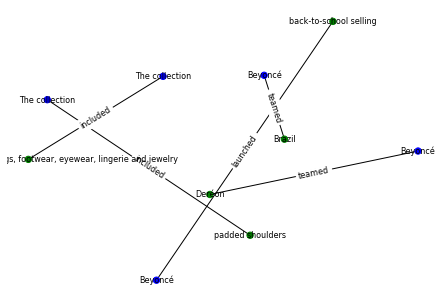

1: 86
4: 107
1: 145
1: 167
1: 212
1: 231
relationTriples 5
node_num:  7


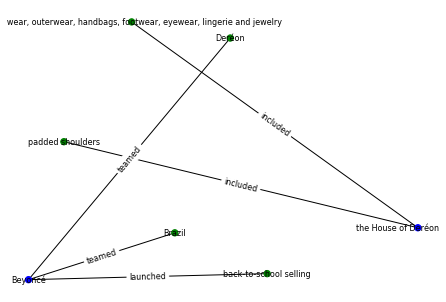

main_entity:  Deréon
--------------
*************
1: 86
4: 107
1: 145
1: 167
1: 212
1: 231
relationTriples 5
node_num:  7


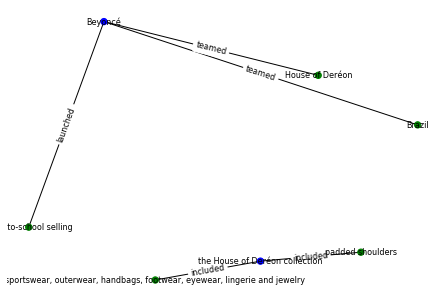

In [136]:
doc_beyonce = nlp(text_Beyonce)
clusters_beyonce = doc_beyonce._.coref_clusters
dict_beyonce = create_tokidx_to_main_dict(clusters_beyonce)
BeyonceTriples = createRelationTriples(text_Beyonce, doc_beyonce)
for triple in BeyonceTriples:
    print(triple[0], "|", triple[1], "|", triple[2], "|", triple[3], "|", triple[4])
draw_graph("/Users/leo/Desktop/Beyonce.png", BeyonceTriples)
apply_coreference(BeyonceTriples, dict_beyonce)
draw_graph("/Users/leo/Desktop/coref_Beyonce.png", BeyonceTriples)
merge_potential_coreference(clusters_beyonce)
new_dict_beyonce = create_tokidx_to_main_dict(clusters_beyonce)
apply_coreference(BeyonceTriples, new_dict_beyonce)
draw_graph("/Users/leo/Desktop/my_coref_Beyonce.png", BeyonceTriples)

In [76]:
def run_knowledge_graph(text, save_path1, save_path2, save_path3):
    doc_ = nlp(text)
    clusters_ = doc_._.coref_clusters
    dict_ = create_tokidx_to_main_dict(clusters_)
    triples = createRelationTriples2(text, doc_)
    draw_graph(save_path1, triples)
    apply_coreference(triples, dict_)
    draw_graph(save_path2, triples)
    merge_potential_coreference(clusters_)
    new_dict_ = create_tokidx_to_main_dict(clusters_)
    apply_coreference(triples, new_dict_)
    draw_graph(save_path3, triples)
    return triples

1243
relationTriples 318
node_num:  636


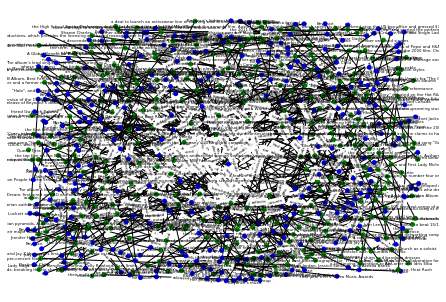

1: 4
1: 81
4: 117
1: 161
1: 298
1: 435
1: 471
4: 496
1: 512
4: 514
4: 542
4: 561
1: 676
1: 695
1: 729
4: 731
1: 802
1: 821
1: 848
1: 904
4: 906
4: 1072
1: 1101
1: 1111
1: 1137
1: 1165
4: 1172
1: 1188
4: 1191
1: 1250
1: 1360
1: 1377
1: 1441
4: 1443
4: 1473
1: 1493
4: 1496
1: 1521
4: 1536
1: 1551
1: 1572
1: 1595
1: 1622
1: 1629
1: 1662
1: 1690
1: 1728
1: 1784
1: 1799
1: 1899
1: 1913
1: 2024
1: 2035
1: 2126
1: 2241
1: 2412
1: 2472
1: 2556
1: 2621
1: 2652
1: 2720
1: 2783
1: 2837
4: 2845
1: 2890
1: 2951
1: 2969
1: 3037
1: 3126
1: 3174
1: 3207
1: 3238
1: 3268
1: 3285
4: 3289
1: 3299
1: 3322
1: 3389
1: 3531
1: 3565
1: 3584
1: 3622
4: 3624
4: 3648
1: 3670
1: 3684
1: 3882
1: 3926
4: 3928
1: 4017
4: 4144
1: 4204
1: 4248
1: 4259
1: 4306
1: 4317
1: 4366
4: 4373
1: 4430
1: 4470
1: 4535
4: 4541
1: 4567
4: 4572
1: 4581
1: 4622
1: 4790
1: 4811
1: 4917
1: 5022
1: 5053
1: 5125
1: 5136
1: 5182
1: 5216
1: 5286
1: 5313
1: 5332
1: 5382
1: 5428
1: 5461
1: 5488
1: 5516
1: 5537
1: 5564
1: 5639
4: 5643
1: 5713


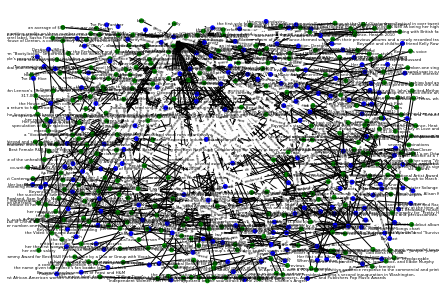

main_entity:  America
--------------
*************
main_entity:  Anita Baker
--------------
*************
main_entity:  B'Day
--------------
*************
main_entity:  Beyoncé
--------------
Beyoncé Giselle Knowles to merge

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) to merge

Beyoncé and Gaga don't merge

Beyoncé and Jay Z don't merge

Beyoncé and Jay-Z don't merge

Beyoncé and childhood friend Kelly Rowland don't merge

Beyoncé and her mother don't merge

Beyoncé names Michael Jackson as her major musical influence to merge

Beyoncé was one of many entertainers who performed for the family of Libyan ruler Muammar Gaddafi to merge

Beyoncé's father don't merge

Beyoncé's second consecutive number-one album in the United States don't merge

Beyoncé's second solo album B'Day don't merge

*************
main_entity:  Billboard
--------------
Billboard to merge

*************
main_entity:  Blue Ivy
--------------
Blue Ivy's don't merge

************

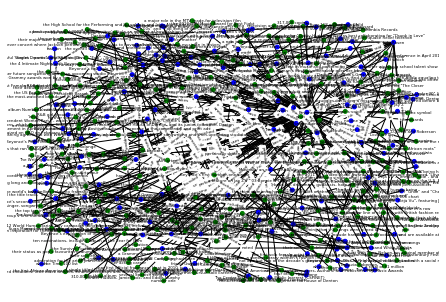

In [77]:
triples = run_knowledge_graph(text_Beyonce,"/Users/leo/Desktop/Beyonce2.png", "/Users/leo/Desktop/coref_Beyonce2.png", "/Users/leo/Desktop/my_coref_Beyonce2.png")

In [78]:
for triple in triples:
    print(triple[0], "|", triple[1], "|", triple[2], "|", triple[3], "|", triple[4])

Beyoncé | Carter | is | an American singer, songwriter, record producer and actress | singer
R&B girl-group Destiny's Child | group | became | one of the world's best-selling girl groups of all time | one
which | which | established | Beyoncé | her
the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, | release | earned | five Grammy Awards | Awards
Beyoncé | she | released | her second solo album, B'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar" | album
which | which | contained | hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar" | hits
Her marriage to rapper Jay Z and portrayal of Etta James in Cadillac Records (2008) | marriage | influenced | her third album | album
which | which | saw | the birth of her alter-ego Sasha Fierce | birth
Beyoncé | Beyoncé | took | a hiatus | hiatus
Beyoncé | she | sold | over 118 million records | records
Beyoncé | She | won | 20 Grammy Awards | Awards


Her mother | mother | wrote | a book, published in 2002, titled Destiny's Style an account of how fashion had an impact on the trio's success | book
fashion | fashion | had | an impact on the trio's success | impact
The B'Day Anthology Video Album | Album | showed | many instances of fashion-oriented footage | instances
People magazine | magazine | recognized | Beyoncé | Beyoncé
The Bey Hive | Hive | is | the name given to Beyoncé's fan base | name
the animal rights organization People for the Ethical Treatment of Animals (PETA) | organization | criticized | Beyoncé | Beyoncé
that | that | drew | criticism | criticism
it | it | was | "a return to her African roots" | return
Beyoncé's lighter skin color and costuming | color | drawn | criticism | criticism
race | race | plays | a role | role
white celebrities who dress | celebrities | attract | as many comments | comments
Beyoncé | Beyoncé | criticized | H&M | H&M
When The Guardian | she | made | not one but two of the decade's greatest

In [79]:
def related_entities(save_path, relationTriples, one_entity):
    print("relationTriples", len(relationTriples))
    G = nx.Graph()
    node_num=0
    for triple in relationTriples:
        if triple[0].text == one_entity:
            G.add_node(triple[0])
            G.add_node(triple[3])
            G.add_edge(triple[0], triple[3], color='black', title=triple[2].text)

        if triple[3].text == one_entity:
            G.add_node(triple[0])
            G.add_node(triple[3])
            G.add_edge(triple[0], triple[3], color='black', title=triple[2].text)

    edge_colors = nx.get_edge_attributes(G, 'color')
    pos = nx.spring_layout(G,k=0.9,iterations=2)
    edge_labels = nx.get_edge_attributes(G, 'title')
    nx.draw(G, pos, node_size=15, font_size=4,with_labels=True,edge_color=edge_colors.values())
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=4, font_color='k', font_family='sans-serif',
        font_weight='normal', alpha=1.0)
    plt.savefig(save_path, dpi=300)
    plt.draw()
    plt.show()

relationTriples 318


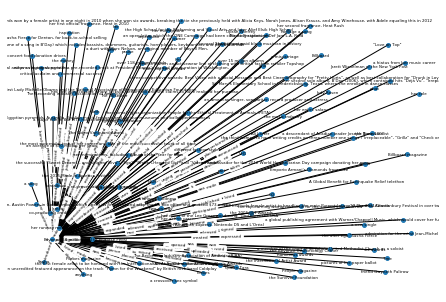

In [80]:
related_entities("/Users/leo/Desktop/BeyonceEntity.png", triples, "Beyoncé")

relationTriples 318


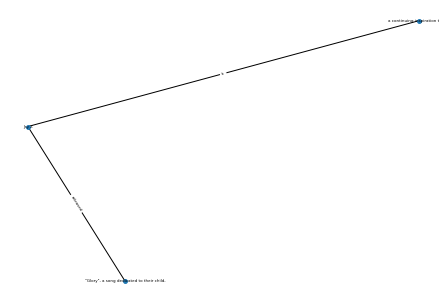

In [81]:
related_entities("/Users/leo/Desktop/JayEntity.png", triples, "Jay Z")

In [123]:
def get_relation(save_path, relationTriples, entity1, entity2):
    print("relationTriples", len(relationTriples))
    G = nx.Graph()
    node_num=0
    for triple in relationTriples:
        if triple[0].text == entity1 and triple[3].text == entity2:
            G.add_node(triple[0])
            G.add_node(triple[3])
            G.add_edge(triple[0], triple[3], color='black', title=triple[2].text)

    edge_colors = nx.get_edge_attributes(G, 'color')
    pos = nx.spring_layout(G,k=0.9,iterations=2)
    edge_labels = nx.get_edge_attributes(G, 'title')
    nx.draw(G, pos, node_size=45, font_size=10,with_labels=True,edge_color=edge_colors.values())
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=10, font_color='k', font_family='sans-serif',
        font_weight='normal', alpha=1.0)
    plt.savefig(save_path, dpi=300)
    plt.draw()
    plt.show()

relationTriples 318


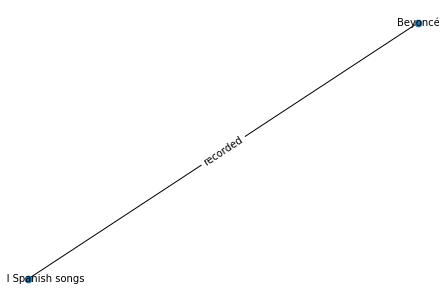

In [133]:
get_relation("/Users/leo/Desktop/beyonce_spanish_song", triples, "Beyoncé", "several Spanish songs")

1235
relationTriples 292
node_num:  584


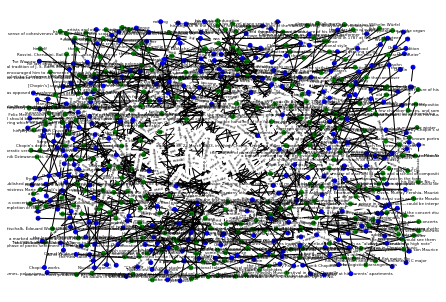

1: 130
1: 186
1: 203
4: 205
1: 222
1: 245
1: 262
1: 315
1: 362
1: 403
1: 480
1: 525
1: 590
1: 669
1: 725
1: 804
1: 815
1: 882
1: 911
1: 954
4: 982
1: 986
1: 1007
1: 1028
1: 1150
4: 1205
1: 1208
1: 1228
1: 1297
4: 1335
4: 1340
1: 1356
4: 1360
1: 1427
1: 1446
1: 1461
4: 1483
1: 1556
4: 1558
1: 1838
1: 1872
4: 1925
1: 1960
1: 1967
4: 1971
1: 2015
1: 2055
1: 2213
1: 2303
1: 2386
1: 2574
1: 2624
4: 2629
1: 2755
4: 2758
4: 2820
1: 2831
1: 2845
1: 3044
1: 3107
4: 3113
1: 3128
4: 3131
4: 3140
1: 3153
1: 3208
1: 3220
4: 3223
1: 3232
1: 3242
1: 3258
4: 3265
1: 3315
4: 3318
1: 3321
1: 3393
4: 3395
1: 3407
1: 3470
4: 3473
4: 3544
1: 3672
1: 3770
1: 3807
1: 3842
1: 3850
1: 3856
1: 3875
1: 3956
1: 3999
1: 4039
1: 4057
1: 4118
1: 4178
4: 4180
1: 4210
1: 4261
4: 4430
1: 4504
4: 4538
4: 4546
1: 4644
1: 4696
1: 4730
4: 4733
1: 4739
1: 4774
1: 4848
1: 4856
1: 4890
1: 4899
1: 4920
4: 5003
1: 5106
1: 5118
1: 5156
1: 5172
4: 5174
1: 5186
1: 5220
1: 5275
4: 5279
1: 5282
1: 5341
1: 5363
4: 5367
1: 5472
1: 562

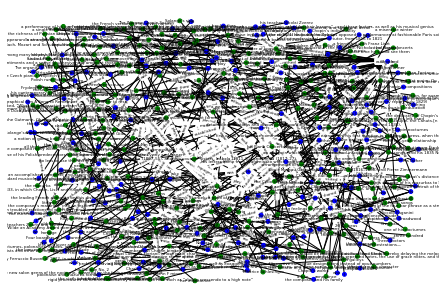

main_entity:  "
Chopin
--------------
"
Chopin's mazurkas and waltzes don't merge

*************
main_entity:  23 unpublished piano pieces
--------------
*************
main_entity:  Bach
--------------
*************
main_entity:  Chopin at 38 Rue de la Chaussée-d'Antin, and Liszt at the Hôtel de France on the Rue Lafitte
--------------
*************
main_entity:  Chopin himself
--------------
*************
main_entity:  Chopin's mazurkas, while originating in the traditional Polish dance (the mazurek)
--------------
*************
main_entity:  Congress Poland
--------------
*************
main_entity:  Düsseldorf, where Mendelssohn had been appointed musical director
--------------
*************
main_entity:  French
--------------
*************
main_entity:  Fryderyk
--------------
*************
main_entity:  Grzymała
--------------
Grzymała " to merge

*************
main_entity:  He
--------------
*************
main_entity:  His
--------------
His elder sister Ludwika to merge

His wal

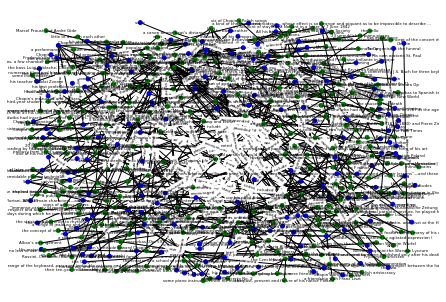

[[what, what, was, the Duchy of Warsaw, Duchy],
 [which, which, became, part of Congress Poland, part],
 [He, he, completed, his musical education, education],
 [He, he, gave, only some 30 public performances, performances],
 [He, He, supported, He, himself],
 [Frédéric François Chopin (/ˈʃoʊpæn/,
  Chopin,
  formed,
  a friendship with Franz Liszt,
  friendship],
 [He, he, obtained, French citizenship, citizenship],
 [He,
  he,
  maintained,
  an often troubled relationship with the French writer George Sand,
  relationship],
 [1838–39,
  1838–39,
  was,
  one of his most productive periods of composition,
  one],
 [He, him, visit, Scotland, Scotland],
 [All of Chopin's compositions, All, include, the piano, piano],
 [He,
  he,
  wrote,
  two piano concertos, a few chamber pieces, and some songs to Polish lyrics,
  concertos],
 [Frédéric François Chopin (/ˈʃoʊpæn/,
  Chopin,
  invented,
  the concept of instrumental ballade,
  concept],
 [His major piano works,
  works,
  include,
  m

In [84]:
run_knowledge_graph(text_Chopin, "/Users/leo/Desktop/chopin.png", "/Users/leo/Desktop/coref_chopin.png", "/Users/leo/Desktop/my_coref_chopin.png")